# `Практикум по программированию на языке Python`
<br>

## `Занятие 14: Ctypes`
<br><br>

### `Находнов Максим (nakhodnov17@gmail.com)`

#### `Москва, 2022`

О чём можно узнать из этого ноутбука:

* Способы профилирования производительности программы
* Методы вызова `C/C++` кода из `Python`-программы

### `Мотивация`

* Python достаточно медленный язык (интерпретируемость, GIL)
* Есть много готовых High Performance библиотек на C/C++

### `Способы ускорить Python`

* Придумать более быстрый алгоритм
* Реализовать алгоритм более эффективно
* Использовать паралелизацию
* Использовать более производительные языки программирования

### `Анализ производительнсти алгоритма`

Прежде чем ускорять существующий код нужно определить, какие части дают наибольший вклад во время работы программы

Напишем тестовую программу, для которой будем замерять время работы.

<font color='brown'>**Задача.** Написать функцию `replace_zeros_to_means(X)`, принимающую матрицу $X$. Функция должна вернуть копию матрицы $X$, в которой все нулевые значения в каждом столбце заменены на среднее арифметическое остальных элементов столбца. В случае столбца из одних нулей необходимо заменить все элементы столбца на $0$. Исходная матрица $X$ должна остаться неизменной!
</font>

### `Pure Python решение`

In [1]:
def replace_zeros_to_means_python(X):
    Y = []
    
    for idx in range(len(X)):
        Y.append([])
        for jdx in range(len(X[0])):
            Y[-1].append(X[idx][jdx])
            
    counts = []
    for jdx in range(len(Y[0])):
        counts.append([0.0, 0])
        
    for idx in range(len(Y)):
        for jdx in range(len(Y[0])):
            counts[jdx][0] += Y[idx][jdx]
            counts[jdx][1] += (Y[idx][jdx] != 0)
            
    means = []
    for numerator, denumerator in counts:
        means.append(numerator / denumerator if denumerator else 0.0)
        
    for idx in range(len(Y)):
        for jdx in range(len(Y[0])):
            if Y[idx][jdx] == 0:
                Y[idx][jdx] = means[jdx]
    
    return Y

### `Numpy решение`

In [2]:
import numpy as np

def replace_zeros_to_means_numpy(X):
    Y = np.copy(X).astype(np.float32)
    
    zero_mask = Y == 0
    selected_columns = np.any(~zero_mask, axis=0)
    means = np.zeros([1, Y.shape[1]], dtype=np.float32)
    means[:, selected_columns] = np.mean(
        Y[:, selected_columns], axis=0, where=~zero_mask[:, selected_columns], keepdims=True
    )
    Y[zero_mask] = np.repeat(means, Y.shape[0], axis=0)[zero_mask]

    return Y

### `Профайлеры`

Для Python есть много профайлеров как для CPU, так и для GPU и памяти:
* `profile` — медленный, не рекомендуется
* `cProfile` — быстрый
* `line_profiler` — удобен в Jupyter Notebook
* `memory_profiler`
* `scalene` — быстрый, современный

In [3]:
%load_ext line_profiler

In [4]:
%lprun??

In [5]:
X = np.random.randint(0, 3, [1000, 1000])
profile_data = %lprun -rf replace_zeros_to_means_python replace_zeros_to_means_python(X)
profile_data.print_stats()

Timer unit: 1e-07 s

Total time: 1.97122 s
File: C:\Users\nahod\AppData\Local\Temp\ipykernel_24624\2268731769.py
Function: replace_zeros_to_means_python at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def replace_zeros_to_means_python(X):
     2         1          4.0      4.0      0.0      Y = []
     3                                               
     4      1000       1806.0      1.8      0.0      for idx in range(len(X)):
     5      1000      32164.0     32.2      0.2          Y.append([])
     6   1000000    1726808.0      1.7      8.8          for jdx in range(len(X[0])):
     7   1000000    4472605.0      4.5     22.7              Y[-1].append(X[idx][jdx])
     8                                                       
     9         1          4.0      4.0      0.0      counts = []
    10      1000       1611.0      1.6      0.0      for jdx in range(len(Y[0])):
    11      1000       4831.0      4.8   

In [6]:
X = np.random.randint(0, 3, [1000, 1000])
profile_data = %lprun -rf replace_zeros_to_means_numpy replace_zeros_to_means_numpy(X)
profile_data.print_stats()

Timer unit: 1e-07 s

Total time: 0.0151609 s
File: C:\Users\nahod\AppData\Local\Temp\ipykernel_24624\67797404.py
Function: replace_zeros_to_means_numpy at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def replace_zeros_to_means_numpy(X):
     4         1      11796.0  11796.0      7.8      Y = np.copy(X).astype(np.float32)
     5                                               
     6         1       3791.0   3791.0      2.5      zero_mask = Y == 0
     7         1       3543.0   3543.0      2.3      selected_columns = np.any(~zero_mask, axis=0)
     8         1         54.0     54.0      0.0      means = np.zeros([1, Y.shape[1]], dtype=np.float32)
     9         1      46947.0  46947.0     31.0      means[:, selected_columns] = np.mean(
    10         1      19163.0  19163.0     12.6          Y[:, selected_columns], axis=0, where=~zero_mask[:, selected_columns], keepdims=True
    11                                

### `Профилировщик памяти`

* Может работать в line-to-line режиме, но только для функций из модулей

In [7]:
%load_ext memory_profiler

In [8]:
%memit replace_zeros_to_means_python(X)

peak memory: 127.39 MiB, increment: 39.82 MiB


In [9]:
%memit replace_zeros_to_means_numpy(X)

peak memory: 89.95 MiB, increment: 0.01 MiB


In [10]:
%%file mprun_demo.py
import numpy as np

def replace_zeros_to_means_numpy(X):
    Y = np.copy(X).astype(np.float32)
    
    zero_mask = Y == 0
    selected_columns = np.any(~zero_mask, axis=0)
    means = np.zeros([1, Y.shape[1]], dtype=np.float32)
    means[:, selected_columns] = np.mean(
        Y[:, selected_columns], axis=0, where=~zero_mask[:, selected_columns], keepdims=True
    )
    Y[zero_mask] = np.repeat(means, Y.shape[0], axis=0)[zero_mask]

    return Y

Overwriting mprun_demo.py


In [11]:
from mprun_demo import replace_zeros_to_means_numpy
%mprun -f replace_zeros_to_means_numpy replace_zeros_to_means_numpy(X)

### `Ускорение кода`

Есть несколько способов как ускорить программу. Попробуем воспользоваться знанием HP языков и перепишем её на `C`.

### `Ctypes`

`Ctypes` — стандартная библиотека языка `Python`, позволяющая вызывать функции из разделяемых библиотек (Shared Libraries, обычно `.so`-файлы) и DLL (`.dll`-файлы).

In [12]:
import ctypes

### `Разделяемые библиотеки С/C++`

* `Ctypes` — может работать только с `С` библиотеками
* Для использования `C++` нужно использовать `extern "C"`, чтобы получить библиотеку с С-ABI

In [13]:
! gcc -shared -o ./ctypes_examples/bin/libctypes_c.dll -fPIC ./ctypes_examples/purec.c

### `Ctypes. Загрузка библиотеки` 

In [14]:
import platform

shared_lib_suffix = 'dll' if platform.system() == 'Windows' else 'so'
library = ctypes.CDLL(f'./ctypes_examples/bin/libctypes_c.{shared_lib_suffix}')

### `Ctypes. Работа с функциями`

Перед использованием функций нужно корректно проанотировать типы аргументов и тип возвращаемого значения.

Также, при использовании ввода-вывода внутри внешнего кода нужно помнить о буферизации.

<!-- None, integers, bytes objects and (unicode) strings are the only native Python objects that can directly be used as parameters in these function calls. None is passed as a C NULL pointer, bytes objects and strings are passed as pointer to the memory block that contains their data (char* or wchar_t*). Python integers are passed as the platforms default C int type, their value is masked to fit into the C type.

All Python types except INTEGERS, STRINGS, and BYTES objects have to be wrapped in their corresponding ctypes type, so that they can be converted to the required C data type -->

In [15]:
import sys

### `Ctypes. Пример с int`

```C
int func_ret_int(int val) {
    printf("get func_ret_int: %d\n", val);
    return val;
}
```

In [16]:
# Указываем, что функция возвращает int
library.func_ret_int.restype = ctypes.c_int
# Указываем, что функция принимает аргумент int
library.func_ret_int.argtypes = [ctypes.c_int]

In [17]:
print('ret func_ret_int: ', library.func_ret_int(101))

ret func_ret_int:  101


### `Ctypes. Пример с double`

```C
double func_ret_double(double val) {
    printf("get func_ret_double: %f\n", val);
    return val;
}
```

In [18]:
# Указываем, что функция возвращает double
library.func_ret_double.restype = ctypes.c_double
# Указываем, что функция принимает аргумент double
library.func_ret_double.argtypes = [ctypes.c_double]

In [19]:
print('ret func_ret_double: ', library.func_ret_double(12.123456789))

ret func_ret_double:  12.123456789


### `Ctypes. Пример с char *`

```C
char * func_ret_str(char * val) {
    printf("get func_ret_str: %s\n", val);
    return val;
}
```

In [20]:
# Указываем, что функция возвращает char *
# ctypes.c_char_p -- указатель нуль-терминированных строк
library.func_ret_str.restype = ctypes.c_char_p
# Указываем, что функция принимает аргумент char *
# ctypes.POINTER -- произвольный указатель
library.func_ret_str.argtypes = [ctypes.POINTER(ctypes.c_char)]

In [21]:
# Необходимо строку привести к массиву байтов, затем полученный массив байтов приводим к строке.
print('ret func_ret_str: ', library.func_ret_str('Hello!'.encode('utf-8')).decode('utf-8'))

ret func_ret_str:  Hello!


### `Ctypes. Пример с несколькими агрументами`

```C
char func_many_args(int val1, double val2, char val3, short val4) {
    printf("get func_many_args: int - %d, double - %f, char - %c, short - %d\n", val1, val2, val3, val4);
    return val3;
}
```

In [22]:
# Указываем, что функция возвращает char
library.func_many_args.restype = ctypes.c_char
# Указываем, что функция принимает аргументы int, double, char, short
library.func_many_args.argtypes = [ctypes.c_int, ctypes.c_double, ctypes.c_char, ctypes.c_short]

In [23]:
# Необходимо строку привести к массиву байтов, затем полученный массив байтов приводим к строке.
print('ret func_many_args: ', library.func_many_args(15, 18.1617, 'X'.encode('utf-8'), 32000).decode('utf-8'));

ret func_many_args:  X


### `Ctypes. Работа с глобальными переменными`

Допустим в библиотеке определены следующие переменные:

```C
int a = 5;
double b = 5.12345;
char c = 'X';
```

Определим вспомогательную функцию, которая их выводит:
```C
void func_print_globals(){
    printf("global variables: a - %d, b - %f, c - %c\n", a, b, c);
}
```

### `Ctypes. Получение значения переменных`

In [24]:
# Указываем, что переменная типа int
a = ctypes.c_int.in_dll(library, 'a')
print('ret a: ', a.value)

ret a:  5


In [25]:
# Указываем, что переменная типа double
b = ctypes.c_double.in_dll(library, 'b')
print('ret b: ', b.value)

ret b:  5.12345


In [26]:
# Указываем, что переменная типа char
c = ctypes.c_char.in_dll(library, 'c')
print('ret c: ', c.value.decode('utf-8'))

ret c:  X


### `Ctypes. Изменение значения переменных`

In [27]:
# Изменяем значение переменной.
a.value = 22
a = ctypes.c_int.in_dll(library, 'a')
print('ret a: ', a.value)

ret a:  22


In [28]:
a.value = 317
b.value = 0.317
c.value = 'B'.encode('utf-8')
library.func_print_globals()

47

По умолчанию возвращаемый тип у функций `long`. Установим тип `void`:

In [29]:
library.func_print_globals.restype = None
library.func_print_globals()

### `Ctypes. Работа со структурами`

Для работы со структурами нужно скопировать интерфейс из библиотеки:
```C
struct test_st_t {
    int val1;
    double val2;
    char val3;
    int * array;
};
```

In [30]:
class TestST(ctypes.Structure):
    _fields_ = [('val1', ctypes.c_int),
                ('val2', ctypes.c_double),
                ('val3', ctypes.c_char)]

    def __str__(self):
        return f'val1 - {self.val1}, val2 - {self.val2}, val3 - {self.val3.decode("utf8")}'

Теперь такой тип можно использовать как валидный ctypes тип

### `Ctypes. Работа со структурами. Передача по значению`

```C
double func_struct(test_st_t test_st){
    printf("get by value test_st: val1 - %d, val2 - %f, val3 - %c\n", test_st.val1, test_st.val2, test_st.val3);

    return test_st.val1 + test_st.val2;
}
```

In [31]:
# Указываем, что функция возвращает double
library.func_struct.restype = ctypes.c_double
# Указываем, что функция принимает аргумент TestST
library.func_struct.argtypes = [TestST]

In [32]:
# Создаем структуру
test_st = TestST(19, 3.5, 'Z'.encode('utf-8'))
print(f'ret func_struct: ', library.func_struct(test_st))

ret func_struct:  22.5


### `Ctypes. Работа со структурами. Передача по указателю`

Для передачи по указателю можно использовать специальную обёртку `ctypes.POINTER` для создания указателя на данный тип.

При этом, 

Разыменование указателя выполянется с помощью аттрибута `.contents`.

```C
test_st_t * func_ret_struct(test_st_t *test_st) {
    if (test_st) {
        printf(
            "get by pointer test_st: val1 - %d, val2 - %f, val3 - %c\n", 
            test_st->val1, test_st->val2, test_st->val3
        );
    } else {
        printf("get by pointer test_st: null pointer\n");
    }

    return test_st;
}
```

In [33]:
# Указываем, что функция возвращает TestST *
library.func_ret_struct.restype = ctypes.POINTER(TestST)
# Указываем, что функция принимает аргумент TestST *
library.func_ret_struct.argtypes = [ctypes.POINTER(TestST)]

In [34]:
if ret := library.func_ret_struct(None):
    print(f'ret func_ret_struct: {ret.contents}')
else:
    print('ret func_ret_struct: null pointer')

ret func_ret_struct: null pointer


In [35]:
if ret := library.func_ret_struct(test_st):
    print(f'ret func_ret_struct: {ret.contents}')
else:
    print('ret func_ret_struct: null pointer')

ret func_ret_struct: val1 - 19, val2 - 3.5, val3 - Z


### `Ctypes. Указатели`

Для того, чтобы получить адрес сущестувующего объекта можно использьзовать следующие методы:
* `pointer` — создаёт объект типа `ctypes.POINTER`, ссылающийся на переданный аргумент 
* `byref` — используется для передачи объектов по ссылке. Значительно более легковесный метод
* В некоторых случаях преобразование типов выполниться автоматически

```C
double * func_add_out(const double * left, const double * right, double * result){
    *result = *left + *right;
    return result;
}
```

In [36]:
# Указываем, что функция возвращает double *
library.func_add_out.restype = ctypes.POINTER(ctypes.c_double)
# Указываем, что функция принимает аргумент double *, double *, double *
library.func_add_out.argtypes = [
    ctypes.POINTER(ctypes.c_double), ctypes.POINTER(ctypes.c_double), ctypes.POINTER(ctypes.c_double)
]

In [37]:
left, right, result = ctypes.c_double(300.0), ctypes.c_double(17.0), ctypes.c_double()
print(left, right, result)
res = library.func_add_out(left, right, result)
print(left, right, result, res.contents)

c_double(300.0) c_double(17.0) c_double(0.0)
c_double(300.0) c_double(17.0) c_double(317.0) c_double(317.0)


In [38]:
res.contents.value = 100500.0
print(left, right, result, res.contents)

c_double(300.0) c_double(17.0) c_double(100500.0) c_double(100500.0)


### `Ctypes. Работа с массивами`

Рассмотрим функцию для сложения двух векторов:

```C
void func_add_arrays_out(const double * left, const double * right, double * result, unsigned long long n){
    for(unsigned long long i = 0; i < n; ++i) {
        result[i] = left[i] + right[i];
    }
}
```

In [39]:
library.func_add_arrays_out.restype = ctypes.POINTER(ctypes.c_double)
library.func_add_arrays_out.argtypes = [
    ctypes.POINTER(ctypes.c_double), ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double), ctypes.c_ulonglong
]

Однако, как передавать данные в такую функцию? 

Есть несколько способов создать массив без использования обёрток над `new/malloc`.

### `Ctypes. Internal Arrays`

Ctypes позволяет создавать массивы фиксированной длины из уже существующих типов:

In [40]:
# Эквивалентно int array[10]. Т.е. эта конструкция -- новый класс
double_array_10 = ctypes.c_double * 10
double_array_10

__main__.c_double_Array_10

### `Ctypes. Internal Arrays. Создание. Способ 1`

In [41]:
# 1 Способ: создание internal массива из списка (медленно)
left_array = double_array_10(*[i for i in range(10)])
right_array = double_array_10(*[2.0 * i for i in range(10)])
result_array = double_array_10()

In [42]:
library.func_add_arrays_out(left_array, right_array, result_array, 10)
print(result_array[:])

[0.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0, 27.0]


### `Ctypes. Internal Arrays. Создание. Способ 2`

In [43]:
from array import array

In [44]:
# 2 Способ: создание internal массива из underlying memory в array (быстро)
left_array = double_array_10.from_buffer(array('d', (i for i in range(10))))
right_array = double_array_10.from_buffer(array('d', (2.0 * i for i in range(10))))
result_array = double_array_10.from_buffer(array('d', (0.0 for i in range(10))))

In [45]:
library.func_add_arrays_out(left_array, right_array, result_array, 10)
print(result_array[:])

[0.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0, 27.0]


### `Ctypes. Pointers. Создание. Способ 3`

In [46]:
# 3 Способ: создание internal массива из прямой конвертацией указателя в C указатель (ещё быстрее)
left_array = array('d', (i for i in range(10)))
right_array = array('d', (2.0 * i for i in range(10)))
result_array = array('d', (0.0 for i in range(10)))

In [47]:
library.func_add_arrays_out(
    ctypes.cast(left_array.buffer_info()[0], ctypes.POINTER(ctypes.c_double)),
    ctypes.cast(right_array.buffer_info()[0], ctypes.POINTER(ctypes.c_double)),
    ctypes.cast(result_array.buffer_info()[0], ctypes.POINTER(ctypes.c_double)),
    10
)
print(result_array)

array('d', [0.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0, 27.0])


### `Ctypes. Pointers. Создание. Способ 4`

In [48]:
left_array = np.array([2.0 * i for i in range(10)], dtype=np.double)
right_array = np.array([i for i in range(10)], dtype=np.double)
result_array = np.array([0.0 for i in range(10)], dtype=np.double)

In [49]:
library.func_add_arrays_out(
    left_array.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    right_array.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    result_array.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    10
)
print(result_array[:])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


### `Ctypes. Сравнение скорости`

Сравним скорость трёх реализаций сложения массивов:
1. `numpy` реализация
2. `Pure Python` реализация
3. `C` расширения

In [50]:
import time

In [51]:
n = 100_000_000

In [52]:
# Numpy
start_numpy_create = time.time()

left_numpy = np.array([1.0 * i for i in range(n)], dtype=np.double)
right_numpy = np.array([2.0 * i for i in range(n)], dtype=np.double)
result_numpy = np.empty([n], dtype=np.double)

total_time_numpy_create = time.time() - start_numpy_create

start_numpy = time.time()
result_numpy = left_numpy + right_numpy
total_time_numpy = time.time() - start_numpy

In [53]:
# Python lists
start_lists_create = time.time()

left_lists = [1.0 * i for i in range(n)]
right_lists = [2.0 * i for i in range(n)]

total_time_lists_create = time.time() - start_lists_create

start_lists = time.time()
result_lists = [i + j for (i, j) in zip(left_lists, right_lists)]
total_time_lists = time.time() - start_lists

In [54]:
# C function + lists
start_c_lists_create = time.time()

double_array_n = ctypes.c_double * n

left_c_lists = double_array_n(*[i for i in range(n)])
right_c_lists = double_array_n(*[2.0 * i for i in range(n)])
result_c_lists = double_array_n()

total_c_lists_create = time.time() - start_c_lists_create

start_c_lists = time.time()
library.func_add_arrays_out(left_c_lists, right_c_lists, result_c_lists, n)
total_c_lists = time.time() - start_c_lists

In [55]:
# C function + numpy
start_c_numpy_create = time.time()

left_numpy = np.array([1.0 * i for i in range(n)], dtype=np.double)
right_numpy = np.array([2.0 * i for i in range(n)], dtype=np.double)
result_numpy = np.empty([n], dtype=np.double)

total_c_numpy_create = time.time() - start_c_numpy_create

start_c_numpy = time.time()
library.func_add_arrays_out(
    left_numpy.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    right_numpy.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    result_numpy.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    n
)
total_c_numpy = time.time() - start_c_numpy

In [56]:
import pandas as pd

In [57]:
pd.DataFrame(data=[
    (total_c_lists_create, total_c_lists),
    (total_c_numpy_create, total_c_numpy),
    (total_time_numpy_create, total_time_numpy),
    (total_time_lists_create, total_time_lists),
], columns=['Время создания', 'Время выполнения'], index=['lists + C', 'numpy + C', 'numpy', 'lists', ])

,Время создания,Время выполнения
lists + C,23.408000,0.093002
numpy + C,13.183998,0.164001
numpy,12.796028,0.131001
lists,7.771996,4.288001


### `Задача. Ctypes решение`

```C
double * replace_zeros_to_means(double *X, unsigned long long n, unsigned long long m){
    double *Y = malloc(sizeof(double) * n * m);

    for(int i = 0; i < n; ++i){
        for(int j = 0; j < m; ++j){
            Y[i * m + j] = X[i * m + j];
        }
    }

    double *counts_n = malloc(sizeof(double) * m);
    int *counts_d = malloc(sizeof(int) * m);
    double *means = malloc(sizeof(double) * m);

    for(int j = 0; j < m; ++j){
        counts_n[j] = 0.0;
        counts_d[j] = 0;
    }

    for(int i = 0; i < n; ++i){
        for(int j = 0; j < m; ++j){
            counts_n[j] += Y[i * m + j];
            counts_d[j] += (Y[i * m + j] != 0);
        }
    }

    for(int j = 0; j < m; ++j){
        if (counts_d[j]) {
            means[j] = counts_n[j] / counts_d[j];
        } else {
            means[j] = 0.0;
        }
    }

    for(int i = 0; i < n; ++i){
        for(int j = 0; j < m; ++j){
            if(Y[i * m + j] == 0){
                Y[i * m + j] = means[j];
            }
        }
    }

    free(counts_n);
    free(counts_d);
    free(means);

    return Y;
}

void free_double(double *ptr){
    if(ptr){
        free(ptr);
    }
}
```

In [58]:
library.replace_zeros_to_means.restype = ctypes.POINTER(ctypes.c_double)
library.replace_zeros_to_means.argtypes = [
    ctypes.POINTER(ctypes.c_double), 
    ctypes.c_ulonglong, ctypes.c_ulonglong
]

library.free_double.restype = None
library.free_double.argtypes = [ctypes.POINTER(ctypes.c_double)]

In [59]:
times_c, times_numpy, times_python = [], [], []
ns = [40, 80, 100, 200, 400, 800, 1000, 2000, 4000, 8000, 10000]

for n in ns:
    m = n
    X = np.random.randint(0, 3, [n, m]).astype(np.float64)
    
    start_c = time.time()
    Y = library.replace_zeros_to_means(
        X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n, m
    )
    total_c = time.time() - start_c    
    library.free_double(Y)
    
    start_numpy = time.time()
    replace_zeros_to_means_numpy(X)
    total_numpy = time.time() - start_numpy  
    
    start_python = time.time()
    replace_zeros_to_means_python(X)
    total_python = time.time() - start_python 
    
    times_c.append(total_c)
    times_numpy.append(total_numpy)
    times_python.append(total_python)

In [60]:
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
%matplotlib inline

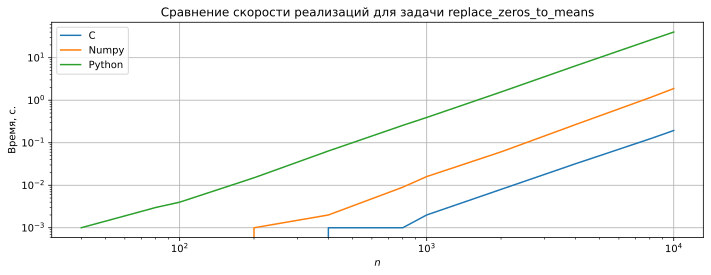

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(ns, times_c, label='C')
ax.plot(ns, times_numpy, label='Numpy')
ax.plot(ns, times_python, label='Python')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$n$')
ax.set_ylabel('Время, с.')
ax.set_title('Сравнение скорости реализаций для задачи replace_zeros_to_means')

ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

**Использование Ctypes позволило уменьшить время работы программы почти на порядок!**

### `Ctypes. C++`

Нужно учитывать, что при загрузке библиотеки должны быть доступны все другие динамические зависимости. Например, если требуется использовать `С++ Standart Library`, то нужно убедиться, что соответсвтующая библиотека указана в `PATH`! 

In [62]:
! g++ -shared --std=c++20 -o ./ctypes_examples/bin/libctypes_cpp.dll -fPIC ./ctypes_examples/cpp.cpp

In [63]:
shared_lib_suffix = 'dll' if platform.system() == 'Windows' else 'so'
ctypes.windll.LoadLibrary("C:/Toolchain/mingw64/bin/libstdc++-6.dll")
library_cpp = ctypes.CDLL(f'./ctypes_examples/bin/libctypes_cpp.dll')

### `Ctypes. C++. Классы`

Рассмотрим класс С++:
```C++
class Test {
public:
    Test(int a, char b, double c): a{a}, b{b}, c{c} {};

    static bool is_prime(int val);
    static bool is_palindrome(const std::string& string);
public:
    int a;
    char b;
    double c;

    std::vector<double> vector;
};
```

### ```Ctypes. C++. Создание объекта```

Так как `ctypes` работает только через `C ABI`, то для создания класса и взаимодействия с ним нужно реализовать обёртки, подчинающиеся `C` соглашению о вызовах.

```C++
// Создаем класс test, и получаем указатель на него.
Test* test_new(int a, char b, double c) {
    return new Test(a, b, c);
}

// Удаляем класс test.
void test_del(Test * test) {
    delete test;
}
```

При создании объекта мы не имеем возможности отобразить его на стандартные типы `Python/ctypes`. Поэтому, единственный способ взаимодействия с таким объектом — через универсальный указатель `void *`. Такой объект будет по-сути чёрным ящиком. Однако, нужно учитывать, что выделением и отчищением памяти должнен заниматься сам пользователь! 

При этом сам объект можно передавать в качестве первого аргумента в соответствующие функции-обёртки. 

In [64]:
# Указываем, что функция возвращает void *
library_cpp.test_new.restype = ctypes.c_void_p
# Указываем, что функция принимает аргумент int, char, double
library_cpp.test_new.argtypes = [ctypes.c_int, ctypes.c_char, ctypes.c_double]

In [65]:
# Создание класса test
test = library_cpp.test_new(10, 'C'.encode('utf-8'), 713.0)

### ```Ctypes. C++. Вызов методов класса```

```C++
bool test_is_prime(Test * test, int val){
    return test->is_prime(val);
}

bool test_is_palindrome(Test * test, char * c_ptr){
    std::string string(c_ptr);

    return test->is_palindrome(string);
}
```

In [66]:
# Указываем, что функция возвращает char *
library_cpp.test_is_prime.restype = ctypes.c_bool
# Указываем, что функция принимает аргумент void * и char *
library_cpp.test_is_prime.argtypes = [ctypes.c_void_p, ctypes.c_int]

# Указываем, что функция возвращает int
library_cpp.test_is_palindrome.restype = ctypes.c_bool
# Указываем, что функция принимает аргумент void * и int
library_cpp.test_is_palindrome.argtypes = [ctypes.c_void_p, ctypes.c_char_p]

In [67]:
print('ret test_is_prime: {0}'.format(library_cpp.test_is_prime(test, 317)))

ret test_is_prime: True


In [68]:
print('ret test_is_palindrome: {0}'.format(library_cpp.test_is_palindrome(test, 'nolemon,nomelon'.encode('utf-8'))))

ret test_is_palindrome: True


### ```Ctypes. C++. Обращение к переменным класса```

Работа с переменными также должна вестись через функции-обёртки: геттеры и сеттеры:
        
```C++
int test_get_a(Test * test){
    return test->a;
}

char test_get_b(Test * test){
    return test->b;
}

double test_get_c(Test * test){
    return test->c;
}
```

In [69]:
library_cpp.test_get_a.restype = ctypes.c_int
library_cpp.test_get_a.argtypes = [ctypes.c_void_p]

library_cpp.test_get_b.restype = ctypes.c_char
library_cpp.test_get_b.argtypes = [ctypes.c_void_p]

library_cpp.test_get_c.restype = ctypes.c_double
library_cpp.test_get_c.argtypes = [ctypes.c_void_p]

In [70]:
print('ret test_get_a: ', library_cpp.test_get_a(test))
print('ret test_get_b: ', library_cpp.test_get_b(test).decode("utf-8"))
print('ret test_get_c: ', library_cpp.test_get_c(test))

ret test_get_a:  10
ret test_get_b:  C
ret test_get_c:  713.0


### ```Ctypes. C++. Стандартная библиотека```

Работа со структурами данных и алгоритмами из стандартной библиотеки также должна проходить через обёртки:

```C++
std::vector<double> * test_get_vector(Test * test){
    return &test->vector;
}

double test_vector_index(std::vector<double> * vector, unsigned long long idx){
    return *(vector->begin() + idx);
}

void test_vector_push_back(std::vector<double> * vector, double value){
    vector->push_back(value);
}

void test_vector_print(std::vector<double> * vector){
    std::cout << "Vector contains: ";
    for(auto v : *vector){
        std::cout << v << ' ';
    }
    std::cout << std::endl;
}
```

In [71]:
library_cpp.test_get_vector.restype = ctypes.c_void_p
library_cpp.test_get_vector.argtypes = [ctypes.c_void_p]

library_cpp.test_vector_index.restype = ctypes.c_double
library_cpp.test_vector_index.argtypes = [ctypes.c_void_p, ctypes.c_ulonglong]

library_cpp.test_vector_push_back.restype = None
library_cpp.test_vector_push_back.argtypes = [ctypes.c_void_p, ctypes.c_double]

library_cpp.test_vector_print.restype = None
library_cpp.test_vector_print.argtypes = [ctypes.c_void_p]

In [72]:
vector = library_cpp.test_get_vector(test)

In [73]:
library_cpp.test_vector_push_back(vector, 1.5)
library_cpp.test_vector_push_back(vector, 2.5)
library_cpp.test_vector_push_back(vector, 3.5)
library_cpp.test_vector_print(vector)

print('vector[0]: {0:.3f}, vector[1]: {1:.3f}, vector[2]: {2:.3f}'.format(
    library_cpp.test_vector_index(vector, 0), 
    library_cpp.test_vector_index(vector, 1), 
    library_cpp.test_vector_index(vector, 2)
))

vector[0]: 1.500, vector[1]: 2.500, vector[2]: 3.500


In [74]:
vector_one_more = library_cpp.test_get_vector(test)
library_cpp.test_vector_print(vector_one_more)
library_cpp.test_vector_push_back(vector, -1.5)
library_cpp.test_vector_print(vector)
print('vector[3]: {0:.3f}, vector_one_more[3]: {1:.3f}'.format(
    library_cpp.test_vector_index(vector, 3), 
    library_cpp.test_vector_index(vector_one_more, 3)
))

vector[3]: -1.500, vector_one_more[3]: -1.500


### `Ctypes. IO`

В некоторых случаях может оказаться что чтение и запись данных в `Python` имеют неудовлетворительную скорость. В таком случае можно также воспользоваться C++ реализацией IO функций: 
```C++
int * test_read_file(const char * path, unsigned long long n){
    auto * array = new int[n];
    std::ifstream file(path);
    for(unsigned long long i = 0; i < n; ++i){
        file >> array[i];
    }
    return array;
}

void test_int_array_delete(const int * array){
    delete[] array;
}
```

In [75]:
library_cpp.test_read_file.restype = ctypes.POINTER(ctypes.c_int)
library_cpp.test_read_file.argtypes = [ctypes.c_char_p, ctypes.c_ulonglong]

library_cpp.test_int_array_delete.restype = None
library_cpp.test_int_array_delete.argtypes = [ctypes.POINTER(ctypes.c_int)]

In [76]:
start_cpp_read = time.time()
data_ptr = library_cpp.test_read_file('data.txt'.encode('utf-8'), 10_000_000)
array_from_data = np.ctypeslib.as_array(data_ptr, shape=[10_000, 1_000])
print('Verify last value: {0}'.format(array_from_data[-1, -1]))
total_time_cpp_read = time.time() - start_cpp_read

library_cpp.test_int_array_delete(data_ptr)

Verify last value: 10998


In [77]:
start_python_read = time.time()
array = np.empty([10_000, 1_000], dtype=np.int32)

with open('data.txt', 'r') as file:
    for idx, line in enumerate(file):
        for jdx, value in enumerate(line.strip().split(' ')):
            array[idx, jdx] = int(value)

array_from_file = array.reshape([10_000, 1_000])
print('Verify last value: {0}'.format(array_from_file[-1, -1]))
total_time_python_read = time.time() - start_python_read

Verify last value: 10998


In [78]:
print('C function time: {0:.3f}'.format(total_time_cpp_read))
print('Pure Python time: {0:.3f}'.format(total_time_python_read))

C function time: 0.678
Pure Python time: 2.266


### `Ctypes. libc`

Также, `ctypes` можно использовать для доступа к функциям стандартной библиотеки языка `C`:

In [79]:
libc = ctypes.cdll.msvcrt if platform.system() == 'Windows' else ctypes.CDLL("libc.so.6")

In [80]:
libc.printf('Hello World!, %s\n'.encode('utf-8'), 'Maksim'.encode('utf-8'))
libc.fflush(None);

In [81]:
int_val = ctypes.c_int()
float_val = ctypes.c_float()
str_val = ctypes.create_string_buffer(1024)
libc.scanf('%d-%f-%s'.encode('utf-8'), ctypes.byref(int_val), ctypes.byref(float_val), str_val)
print(int_val, float_val, str_val.value.decode('utf-8'))

c_long(0) c_float(0.0) 


### `Ctypes. C++. Функции`

Ctypes позволяет передавать `Python` функции внутрь `C/C++` кода. Это может быть полезно для написания `callback функций`.

При этом, такие функции не будут захватывать `GIL`, что позволяет безопасно использовать этот механизм для многопоточных программ.

Рассмотрим использование таких функций на примере компаратора для сортировки:

```C++
typedef int (*comparator_type)(int, int);

void test_sort(int * array, unsigned long long n, comparator_type comparator){
    std::sort(array, array + n, comparator);
}
```

In [82]:
def simple_comparator(a, b):
    return int(a > b)

Создаём тип, соответствующий вызываемой функции:

In [83]:
simple_comparator_type = ctypes.CFUNCTYPE(ctypes.c_int, ctypes.c_int, ctypes.c_int)

In [84]:
library_cpp.test_sort.restype = None
library_cpp.test_sort.argtypes = [ctypes.POINTER(ctypes.c_int), ctypes.c_ulonglong, simple_comparator_type]

In [85]:
array = np.random.randint(0, 100, size=[15])
print("Before sorting: ", array)
library_cpp.test_sort(
    array.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), 15, simple_comparator_type(simple_comparator)
)
print("After sorting (std::sort): ", array)

Before sorting:  [69 43 44 33 19 22 29 14 65 24  8 61 32  6 63]
After sorting (std::sort):  [69 65 63 61 44 43 33 32 29 24 22 19 14  8  6]


### `Ctypes. C++. Функции`

Также, можно использовать и более сложные функции:

In [86]:
def advanced_comparator(a, b):
    return a[0] - b[0]

In [87]:
advanced_comparator_type = ctypes.CFUNCTYPE(ctypes.c_int, ctypes.POINTER(ctypes.c_int), ctypes.POINTER(ctypes.c_int))

In [88]:
array = np.random.randint(0, 100, size=[15])
print("Before sorting: ", array)
libc.qsort(
    array.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), 15,
    ctypes.sizeof(ctypes.c_int), advanced_comparator_type(advanced_comparator)
)
print("After sorting (libc qsort): ", array)

Before sorting:  [ 5 32 51 55 98 36 74 78 53 56 41 51 15 57 43]
After sorting (libc qsort):  [ 5 15 32 36 41 43 51 51 53 55 56 57 74 78 98]


## `Спасибо за внимание!`